In [1]:
import numpy as np
import pandas as pd
from laser_core.propertyset import PropertySet
import matplotlib.pyplot as plt
import itertools

from scipy.optimize import fsolve

from laser_generic import Model
from laser_generic.infection import Infection
from laser_generic.susceptibility import Susceptibility
from laser_generic.transmission import Transmission
from laser_generic.utils import set_initial_susceptibility_randomly
from laser_generic.utils import seed_infections_randomly

f"{np.__version__=}"

"np.__version__='1.26.4'"

In [2]:
scenario = pd.DataFrame(data=[["homenode", 1e6, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])
parameters = PropertySet({"seed": 2, "nticks": 730, "verbose": True, "beta": 0.1, "inf_mean": 50})



2024-12-10 19:22:37.401086: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-10 19:22:37.421751: Running the generic model for 730 ticks…


100%|██████████| 730/730 [00:04<00:00, 176.43it/s]

Completed the generic model at 2024-12-10 19:22:41.573899…
Model         :         4,240 µs
Susceptibility:       684,242 µs
Transmission  :     2,742,311 µs
Infection     :       624,253 µs
Total:              4,055,046 microseconds


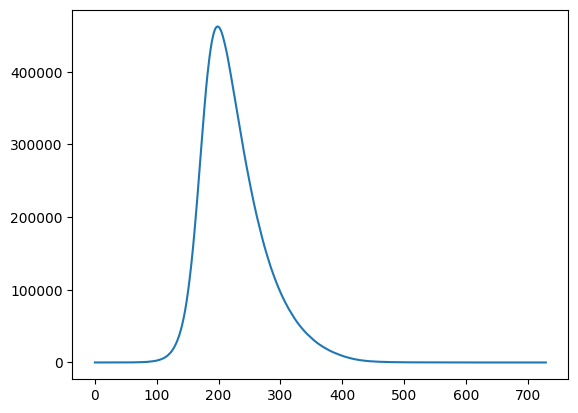

In [3]:
model = Model(scenario, parameters)
model.components = [
    Susceptibility,
    Transmission,
    Infection,
]

set_initial_susceptibility_randomly(model, 1.0)
seed_infections_randomly(model, ninfections=1)
model.run()
plt.plot(model.patches.cases)

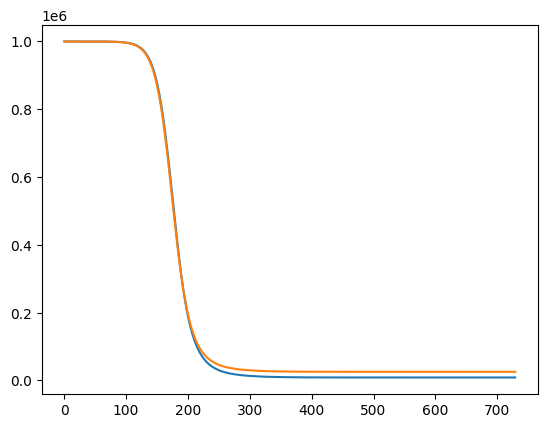

In [4]:
plt.plot(model.patches.susceptibility)
plt.plot(1e6-np.cumsum(model.patches.incidence))


In [9]:
def KM_limit(z, R0, S0, I0):
    if R0*S0 < 1:
        return 0
    else:
        return z - S0*(1-np.exp(-R0*(z+I0)))
population = 1e5
#fsolve(KM_limit, 0, args=(3.0, 0.2, 0.0001))
R0s = np.concatenate((np.linspace(0.2, 1.0, 5), np.linspace(1.5, 10.0, 25)))
S0s = [1.0, 0.8, 0.6, 0.4, 0.2]
output = pd.DataFrame(list(itertools.product(R0s, S0s)), columns=['R0', 'S0'])
output['I_inf_exp'] = [fsolve(KM_limit, 0.5*(R0*S0>=1), args=(R0, S0, 5/population))[0] for R0, S0 in zip(output['R0'], output['S0'])]
output['S_inf_exp'] = output['S0']-output['I_inf_exp']
output['I_inf_obs'] = np.nan
output['S_inf_obs'] = np.nan

In [23]:
%%capture

inf_mean = 20
for index, row in output.iterrows():
    scenario = pd.DataFrame(data=[["homenode", population, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])
    parameters = PropertySet({"seed": 2, "nticks": 730, "verbose": True, "inf_mean": inf_mean, "beta": row['R0']/inf_mean})
    
    model = Model(scenario, parameters)
    model.components = [
        Susceptibility,
        Transmission,
        Infection,
    ]
    
    set_initial_susceptibility_randomly(model, row['S0'])
    seed_infections_randomly(model, ninfections=5)
    model.run()
    
    output.loc[index, 'I_inf_obs'] = np.sum(model.patches.incidence)/population
    output.loc[index, 'S_inf_obs'] = model.patches.susceptibility[-1]/population


# for R0 in R0s:
#     for S0 in S0s:
#         expected = 



In [25]:
output

,R0,S0,I_inf_exp,S_inf_exp,I_inf_obs,S_inf_obs
0,0.2,1.0,0.000000,1.000000,0.00000,0.99995
1,0.2,0.8,0.000000,0.800000,0.00000,0.79996
2,0.2,0.6,0.000000,0.600000,0.00000,0.59995
3,0.2,0.4,0.000000,0.400000,0.00000,0.39995
4,0.2,0.2,0.000000,0.200000,0.00000,0.19995
...,...,...,...,...,...,...
145,10.0,1.0,0.999955,0.000045,0.92267,0.00003
146,10.0,0.8,0.799731,0.000269,0.75435,0.00024
147,10.0,0.6,0.598491,0.001509,0.57484,0.00176
148,10.0,0.4,0.392073,0.007927,0.38233,0.00922


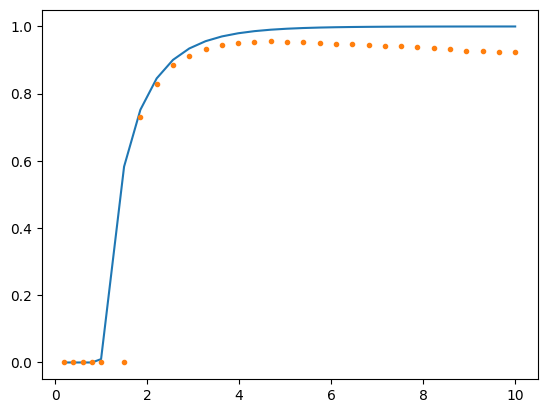

In [43]:
condition = output['S0'] == 1.0
plt.plot(output[condition]['R0'], output[condition]['I_inf_exp'], label='Expected')
plt.plot(output[condition]['R0'], output[condition]['I_inf_obs'], '.', label='Observed')
